In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score

# Min Max scale

In [28]:
def minMaxScale(data):
    min_value = np.min(data, axis=0)
    max_value = np.max(data, axis=0)
    normalized_data = (data - min_value)/(max_value - min_value)
    
    return normalized_data, min_value, max_value

def minMaxDescale(normalized_data, min_value, max_value):
    
    denormalized_data = (normalized_data * (max_value - min_value)) + min_value
    
    return denormalized_data

# K-means

In [29]:
class EuclideanKMeans:
    def __init__(self, n_clusters, max_iter=200):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X):

        # Seleciona k padrões aleatórios dos dados para serem centróides
        self.centroids = X[np.random.choice(range(len(X)), size=self.n_clusters, replace=False)]

        self.clusters = [[] for _ in range(self.n_clusters)]

        for _ in range(self.max_iter):
            clusters = [[] for _ in range(self.n_clusters)]
            
            # Compara as distâncias entre um padrão e todos os centróides, seleciona o 
            # centróide com menor distância e adiciona o padrão a este cluster.
            for x in X:
                distances = [np.linalg.norm(x - centroid) for centroid in self.centroids]
                cluster_idx = np.argmin(distances)
                clusters[cluster_idx].append(x)
            
            # Atualiza cada centróide com a média das posições dos elementos do seu cluster.
            new_centroids = [np.mean(cluster, axis=0) for cluster in clusters]
            if np.array_equal(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

        new_clusters = [[] for _ in range(self.n_clusters)]
        for x in X:
            distances = [np.linalg.norm(x - centroid) for centroid in self.centroids]
            cluster_idx = np.argmin(distances)
            new_clusters[cluster_idx].append(x)
        
        self.clusters = new_clusters

    def cost(self):
        cost = 0
        for c in range(self.n_clusters):
            cost += [np.linalg.norm(cluster - self.centroids[c]) for cluster in self.clusters[c]][0]
        return cost

    def predict(self, X):
        distances = [np.linalg.norm(X - centroid, axis=1) for centroid in self.centroids]
        cluster_indices = np.argmin(distances, axis=0)
        return cluster_indices

In [30]:
class MahalanobisKMeans:
    def __init__(self, n_clusters, max_iter=200):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.cov_matrix = np.array(1)
        self.inv_cov_matrix = np.array(1)

    def mahalanobis_distance(self, x, centroid):
        delta = x - centroid
        return np.sqrt(delta @ self.inv_cov_matrix @ delta.T)

    def fit(self, X):

        # Seleciona k padrões aleatórios dos dados para serem centróides
        self.centroids = X[np.random.choice(range(len(X)), size=self.n_clusters, replace=False)]

        # Cria a matriz de covariância
        self.cov_matrix = np.zeros((X.T.shape[0], X.T.shape[0]))
        self.cov_matrix = np.cov(X.T) + np.identity(self.cov_matrix.shape[0]) * 1e-10
        self.inv_cov_matrix = np.linalg.inv(self.cov_matrix)
        

        for _ in range(self.max_iter):
            clusters = [[] for _ in range(self.n_clusters)]
            
            # Compara as distâncias entre um padrão e todos os centróides, seleciona o 
            # centróide com menor distância e adiciona o padrão a este cluster.
            for x in X:
                distances = [self.mahalanobis_distance(x, centroid) for centroid in self.centroids]
                cluster_idx = np.argmin(distances)
                clusters[cluster_idx].append(x)
            
            # Atualiza cada centróide com a média das posições dos elementos do seu cluster.
            new_centroids = [np.mean(cluster, axis=0) for cluster in clusters]

            if np.array_equal(self.centroids, new_centroids):
                break

            self.centroids = new_centroids
            
        new_clusters = [[] for _ in range(self.n_clusters)]
        for x in X:
            distances = [self.mahalanobis_distance(x, centroid) for centroid in self.centroids]
            cluster_idx = np.argmin(distances)
            new_clusters[cluster_idx].append(x)
        
        self.clusters = new_clusters

    def cost(self):
        cost = 0
        for c in range(self.n_clusters):
            cost += [np.linalg.norm(cluster - self.centroids[c]) for cluster in self.clusters[c]][0]
        return cost

    def predict(self, X):
        distances = [np.linalg.norm(X - centroid, axis=1) for centroid in self.centroids]
        cluster_indices = np.argmin(distances, axis=0)
        return cluster_indices


## Linear-search K-means

In [31]:
def linear_search_k_means(x, mahalanobis = False, max_iter = 200):
    best_k = 4
    best_db = float('inf')
    for k in range(4, 21):

        db_values = np.zeros(20)

        print("\n------------------- k =", k, "-------------------")
        for i in range(20):
            if mahalanobis:
                k_means = MahalanobisKMeans(k, max_iter=max_iter)
            else:
                k_means = EuclideanKMeans(k, max_iter=max_iter)

            k_means.fit(x)
            predictions = k_means.predict(x)
            db_values[i] = davies_bouldin_score(x, predictions)
            print("DB do Modelo", i+1, ":", db_values[i])

        db_mean = db_values.mean()

        print("Média Score Davies-Bouldin:", db_mean)
        
        if db_mean < best_db:
            best_db = db_mean
            best_k = k
    
    print("\n#------------------ best k:", best_k, "------------------#")
    print("Média Score Davies-Bouldin:", best_db)

    return best_k

# PCA

In [32]:
class PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.explained_variance = None
        self.explained_variance_ratio = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        centered_X = X - self.mean
        cov_matrix = np.cov(centered_X.T)
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        eigenpairs = [(np.abs(eigenvalue), eigenvector) for eigenvalue, eigenvector in zip(eigenvalues, eigenvectors)]
        eigenpairs.sort(key=lambda pair: pair[0], reverse=True)
        self.components = np.array([eigenpair[1] for eigenpair in eigenpairs])
        self.eigenvalues = np.array([eigenpair[0] for eigenpair in eigenpairs[:self.n_components]])

        if self.n_components is not None:
            self.components = self.components[:self.n_components]

        full_explained_variance = np.abs(eigenvalues)
        self.explained_variance_ratio = np.sum(self.eigenvalues/full_explained_variance.sum())

    def transform(self, X):
        centered_X = X - self.mean
        return np.dot(centered_X, self.components.T)

# Questão 1

## Preparação dos dados

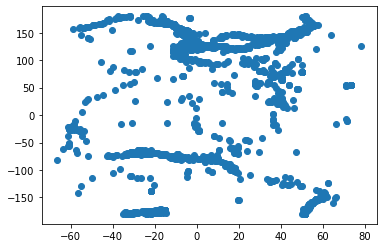

In [33]:
data = np.genfromtxt("quake.csv", delimiter=',')

plt.scatter(data[:, 0], data[:, 1])
plt.show()

## K-médias euclideano

### Obtenção do melhor número de clusters via linear-search

In [34]:
best_k = linear_search_k_means(data, max_iter=200)

print("\nMelhor número de clusters:", best_k)


------------------- k = 4 -------------------
DB do Modelo 1 : 0.656717375639566
DB do Modelo 2 : 0.9648238932643166
DB do Modelo 3 : 0.4708591824745798
DB do Modelo 4 : 0.6938207922840968
DB do Modelo 5 : 0.6938207922840968
DB do Modelo 6 : 0.6567173756395661
DB do Modelo 7 : 0.9042147528131192
DB do Modelo 8 : 0.6567173756395661
DB do Modelo 9 : 0.656717375639566
DB do Modelo 10 : 0.9038805906074789
DB do Modelo 11 : 0.9051115315980649
DB do Modelo 12 : 0.656717375639566
DB do Modelo 13 : 0.9051115315980649
DB do Modelo 14 : 0.6938207922840967
DB do Modelo 15 : 0.656717375639566
DB do Modelo 16 : 0.6936230650389128
DB do Modelo 17 : 0.6567173756395661
DB do Modelo 18 : 0.6936230650389128
DB do Modelo 19 : 0.6938207922840967
DB do Modelo 20 : 0.656717375639566
Média Score Davies-Bouldin: 0.7235134893343182

------------------- k = 5 -------------------
DB do Modelo 1 : 0.6922260926700889
DB do Modelo 2 : 0.935593587399796
DB do Modelo 3 : 0.5229366386263017
DB do Modelo 4 : 0.6884275

### Obtenção do melhor modelo

In [35]:
euclidean_cost_values = np.zeros(20)

best_cost = float('inf')
for i in range(20):
    euclidean_k_means = EuclideanKMeans(best_k, max_iter=200)
    euclidean_k_means.fit(data)
    cost = euclidean_k_means.cost()
    if cost < best_cost:
        best_cost = cost
        best_model = euclidean_k_means
    euclidean_cost_values[i] = cost
    print("\n---------------- Modelo", i+1, "----------------")
    print("Custo de reconstrução:", cost)

mean_euclidean_cost = euclidean_cost_values.mean()

print("\nMédia do custo de reconstrução:", mean_euclidean_cost)



---------------- Modelo 1 ----------------
Custo de reconstrução: 192.3512013321844

---------------- Modelo 2 ----------------
Custo de reconstrução: 192.3512013321844

---------------- Modelo 3 ----------------
Custo de reconstrução: 192.3512013321844

---------------- Modelo 4 ----------------
Custo de reconstrução: 146.2997937331964

---------------- Modelo 5 ----------------
Custo de reconstrução: 181.85764133469345

---------------- Modelo 6 ----------------
Custo de reconstrução: 183.37199365762697

---------------- Modelo 7 ----------------
Custo de reconstrução: 179.01545900927357

---------------- Modelo 8 ----------------
Custo de reconstrução: 179.65373437278555

---------------- Modelo 9 ----------------
Custo de reconstrução: 175.56330117914868

---------------- Modelo 10 ----------------
Custo de reconstrução: 146.33682714877366

---------------- Modelo 11 ----------------
Custo de reconstrução: 186.97125710753662

---------------- Modelo 12 ----------------
Custo de re

Quantidade de clusters: 7


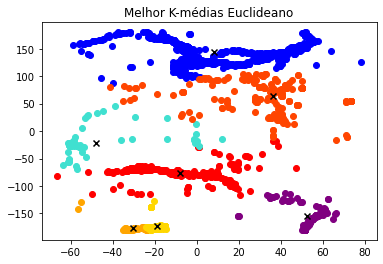

In [36]:
n_clusters = best_model.n_clusters
clusters = best_model.clusters
centroids = best_model.centroids
colors = ["red", 
          "turquoise",
          "blue",
          "orangered",
          "purple",
          "orange",
          "gold",
          "yellow",
          "violet",
          "yellowgreen",
          "deeppink",
          "greenyellow",
          "deepskyblue",
          "lawngreen",
          "mediumorchid",
          "palegreen",
          "aquamarine",
          "mediumpurple",
          "magenta",
          "crimson"]

print("Quantidade de clusters:", n_clusters)

plt.title("Melhor K-médias Euclideano")

for i, cluster in enumerate(clusters):
    for pattern in cluster:
        plt.scatter(pattern[0], pattern[1], c=colors[i])

for centroid in centroids:
    plt.scatter(centroid[0], centroid[1], marker='x', c='black')

plt.show()

## K-médias de Mahalanobis

### Obtenção do melhor número de clusters via linear-search

In [37]:
best_k = linear_search_k_means(data, max_iter=200, mahalanobis=True)

print("\nMelhor número de clusters:", best_k)


------------------- k = 4 -------------------
DB do Modelo 1 : 1.1841349455740176
DB do Modelo 2 : 1.1841349455740176
DB do Modelo 3 : 1.16727668188667
DB do Modelo 4 : 1.1841349455740176
DB do Modelo 5 : 0.7034899916895733
DB do Modelo 6 : 1.1841349455740176
DB do Modelo 7 : 1.16727668188667
DB do Modelo 8 : 0.6937554108015478
DB do Modelo 9 : 1.16727668188667
DB do Modelo 10 : 1.1841349455740176
DB do Modelo 11 : 1.1841349455740176
DB do Modelo 12 : 1.16727668188667
DB do Modelo 13 : 1.1841349455740176
DB do Modelo 14 : 1.1841349455740176
DB do Modelo 15 : 1.16727668188667
DB do Modelo 16 : 1.1841349455740176
DB do Modelo 17 : 1.16727668188667
DB do Modelo 18 : 1.1841349455740176
DB do Modelo 19 : 0.7034899916895734
DB do Modelo 20 : 1.1841349455740176
Média Score Davies-Bouldin: 1.1064939943407452

------------------- k = 5 -------------------
DB do Modelo 1 : 1.1537210034459535
DB do Modelo 2 : 1.137358263420093
DB do Modelo 3 : 0.8013197174670973
DB do Modelo 4 : 0.80131971746709

### Obtenção do erro de reconstrução médio do modelo

In [38]:
mahalanobis_cost_values = np.zeros(20)

best_cost = float('inf')
for i in range(20):
    mahalanobis_k_means = MahalanobisKMeans(best_k, max_iter=200)
    mahalanobis_k_means.fit(data)
    cost = mahalanobis_k_means.cost()
    if cost < best_cost:
        best_cost = cost
        best_model = mahalanobis_k_means
    euclidean_cost_values[i] = cost
    print("\n---------------- Modelo", i+1, "----------------")
    print("Custo de reconstrução:", cost)

mean_euclidean_cost = euclidean_cost_values.mean()

print("\nMédia do custo de reconstrução:", mean_euclidean_cost)


---------------- Modelo 1 ----------------
Custo de reconstrução: 236.6095979238361

---------------- Modelo 2 ----------------
Custo de reconstrução: 274.78826173146734

---------------- Modelo 3 ----------------
Custo de reconstrução: 193.84142932215664

---------------- Modelo 4 ----------------
Custo de reconstrução: 238.5279578048137

---------------- Modelo 5 ----------------
Custo de reconstrução: 238.5279578048137

---------------- Modelo 6 ----------------
Custo de reconstrução: 352.92740532959516

---------------- Modelo 7 ----------------
Custo de reconstrução: 282.83825080021415

---------------- Modelo 8 ----------------
Custo de reconstrução: 270.30482299016194

---------------- Modelo 9 ----------------
Custo de reconstrução: 190.20484900279297

---------------- Modelo 10 ----------------
Custo de reconstrução: 160.97142460481015

---------------- Modelo 11 ----------------
Custo de reconstrução: 160.97142460481012

---------------- Modelo 12 ----------------
Custo de r

Quantidade de clusters: 10


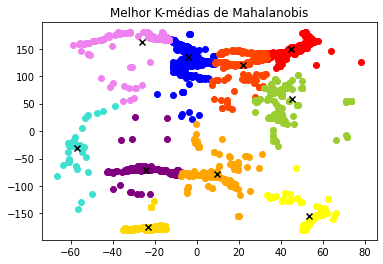

In [39]:
n_clusters = best_model.n_clusters
clusters = best_model.clusters
centroids = best_model.centroids

print("Quantidade de clusters:", n_clusters)

plt.title("Melhor K-médias de Mahalanobis")

for i, cluster in enumerate(clusters):
    for pattern in cluster:
        plt.scatter(pattern[0], pattern[1], c=colors[i])

for centroid in centroids:
    plt.scatter(centroid[0], centroid[1], marker='x', c='black')

plt.show()

# Questão 2

## Preparação dos dados

In [40]:
data = np.genfromtxt("penguins.csv", delimiter=',')

x = data[:, :4]
scaled_x, min_x, max_x = minMaxScale(x)
y = data[:, 4].reshape(-1,1)

## Aplicação do PCA e análise da variância explicada

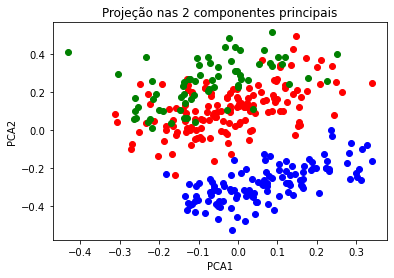

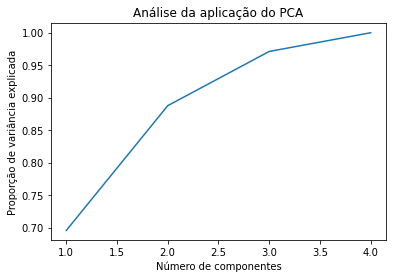

In [41]:
explained_variance = np.zeros(4)

pca_1 = PCA(1)
pca_1.fit(scaled_x)
explained_variance[0] = pca_1.explained_variance_ratio

pca_2 = PCA(2)
pca_2.fit(scaled_x)
explained_variance[1] = pca_2.explained_variance_ratio
transformed_x = pca_2.transform(scaled_x)

pca_3 = PCA(3)
pca_3.fit(scaled_x)
explained_variance[2] = pca_3.explained_variance_ratio

pca_4 = PCA(4)
pca_4.fit(scaled_x)
explained_variance[3] = pca_4.explained_variance_ratio

colors = ['red',
          'green',
          'blue']


plt.title("Projeção nas 2 componentes principais")
for i, pattern in enumerate(transformed_x):
    plt.scatter(pattern[0], pattern[1], c=colors[int(y[i][0])])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

plt.title('Análise da aplicação do PCA')
plt.plot(np.arange(4) + 1, explained_variance)
plt.xlabel('Número de componentes')
plt.ylabel('Proporção de variância explicada')
plt.show()